# Лабораторная работа №5. Разработка единого подхода к предварительной обработке данных.
## Шкуратова Д.В. МКТ

## 1.Данные

In [1]:
import  pandas as pd
import numpy as np
import seaborn as sns




In [2]:
df = pd.read_csv('medical_conditions_dataset.csv')
df.head()

,id,full_name,age,gender,smoking_status,bmi,blood_pressure,glucose_levels,condition
0,1,User0001,NaN,male,Non-Smoker,NaN,NaN,NaN,Pneumonia
1,2,User0002,30.0,male,Non-Smoker,NaN,105.315064,NaN,Diabetic
2,3,User0003,18.0,male,Non-Smoker,35.612486,NaN,NaN,Pneumonia
3,4,User0004,NaN,male,Non-Smoker,NaN,99.119829,NaN,Pneumonia
4,5,User0005,76.0,male,Non-Smoker,NaN,NaN,NaN,Diabetic


In [3]:
df.describe()

,id,age,bmi,blood_pressure,glucose_levels
count,10000.00000,5445.000000,4652.000000,3766.000000,4756.000000
mean,5000.50000,53.541598,27.423420,135.209429,135.219608
std,2886.89568,20.925113,7.231257,26.041531,37.607638
min,1.00000,18.000000,15.012119,90.009620,70.015961
25%,2500.75000,35.000000,21.077894,113.107754,102.273703
50%,5000.50000,54.000000,27.326204,134.821040,135.436764
75%,7500.25000,72.000000,33.689330,157.949509,168.349011
max,10000.00000,89.000000,39.998687,179.999359,199.890429


## Визуализация

<Axes: >

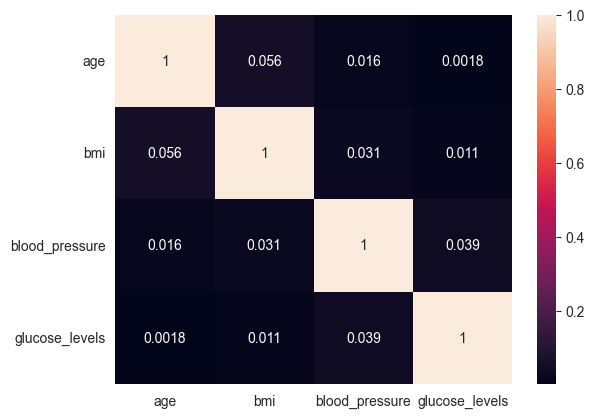

In [6]:
sns.heatmap((df.iloc[:, 2:]).corr(numeric_only=True), annot=True)

Видим, что корреляция между признаками слабая, значит выполняется один из критериев Гаусса-Маркова, при оценке других критериев можно попытаться построить множественную линейную регрессию

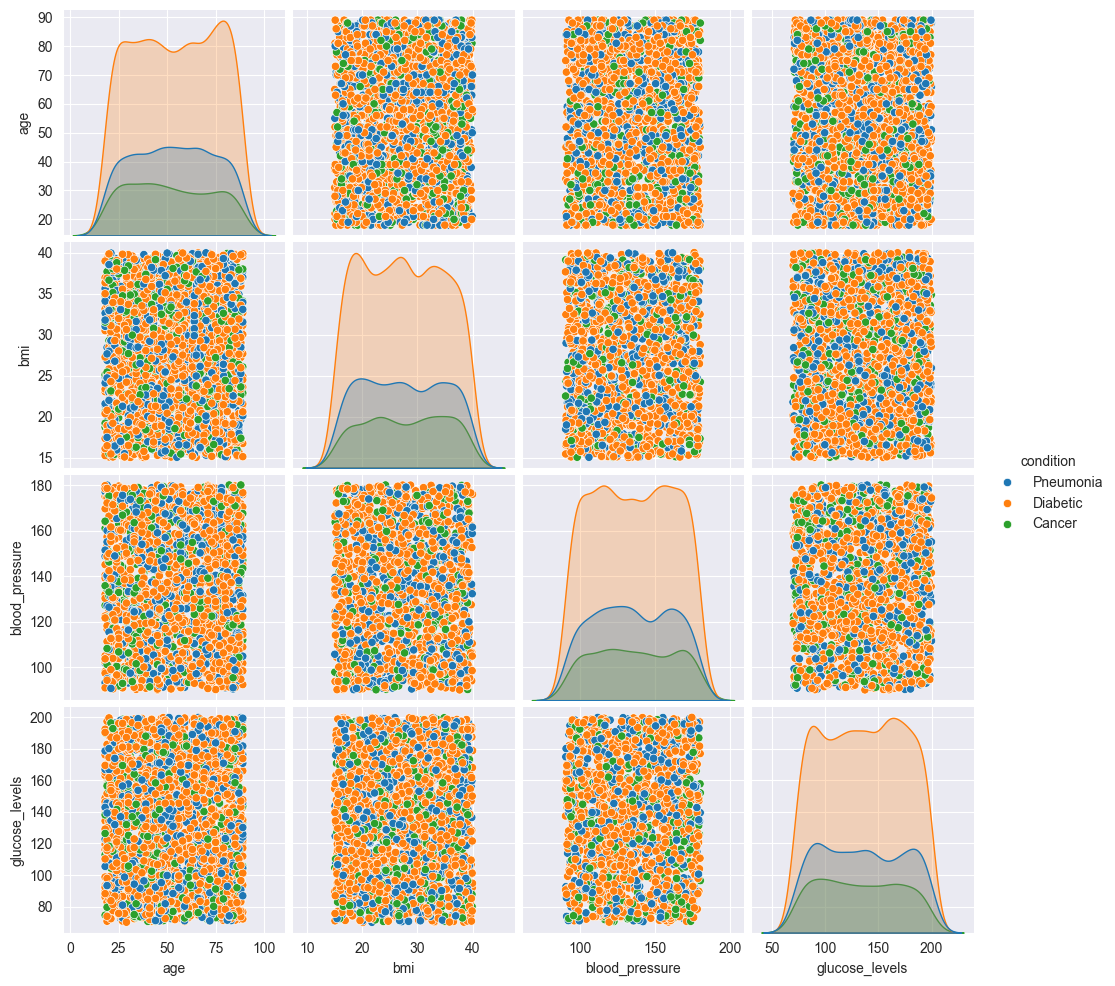

In [9]:
sns.pairplot(data=df.iloc[:, 2:], hue='condition')

По диграммам рассеяния линейная зависимость не выполняется, скорее всего, не получится получить хорошие коэффициенты, по которым можно было бы предсказать какой-либо другой признак.

Все значение сгруппированы по диагнозам, и по графикам мы видим, что для задачи классификации трудно выделить какие-либо значимые признаки

np.int64(0)

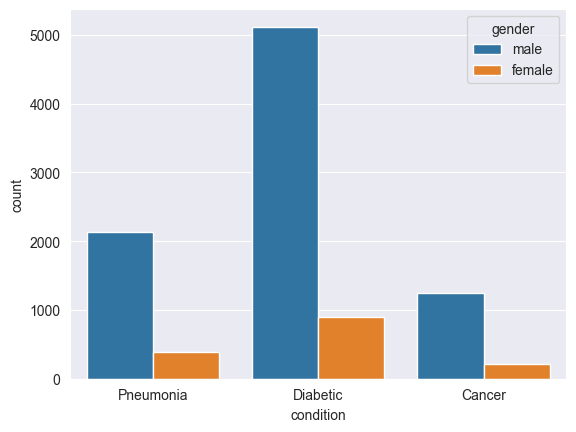

In [19]:
sns.countplot(data = df, x = 'condition', hue='gender')


In [23]:
df['gender'].isna().sum(), df[df['gender'] == 'male'].count()

(np.int64(0),
 id                8506
 full_name         8506
 age               4612
 gender            8506
 smoking_status    8506
 bmi               3941
 blood_pressure    3202
 glucose_levels    4051
 condition         8506
 dtype: int64)

В выборке чаще всего встречаются люди с диабетом, большая часть пациентов - мужчины, можно проверить несколько гипотез:
 - Мужчины чаще заболевают диабетом/пневмонией/раком
  - Среднее значение признака \[age/bmi/blood_pressure/ ... \](1) у женщин страдающих диабетом меньше (неравно) среднему значению признака (1) у мужчин 

Проверим нет ли в выборке людей сразу с несколькими заболеваниями

In [28]:
df['full_name'].unique().size

10000

In [34]:
# Каждый пациент выборки уникален, можем удалить столбцы id и fullname
df.drop(['id', 'full_name'], axis=1)

,age,gender,smoking_status,bmi,blood_pressure,glucose_levels,condition
0,NaN,male,Non-Smoker,NaN,NaN,NaN,Pneumonia
1,30.0,male,Non-Smoker,NaN,105.315064,NaN,Diabetic
2,18.0,male,Non-Smoker,35.612486,NaN,NaN,Pneumonia
3,NaN,male,Non-Smoker,NaN,99.119829,NaN,Pneumonia
4,76.0,male,Non-Smoker,NaN,NaN,NaN,Diabetic
...,...,...,...,...,...,...,...
9995,NaN,male,Non-Smoker,25.029002,152.540355,137.551451,Pneumonia
9996,NaN,male,Non-Smoker,27.017487,NaN,NaN,Diabetic
9997,23.0,male,Smoker,NaN,148.833321,173.931480,Pneumonia
9998,NaN,female,Non-Smoker,NaN,NaN,NaN,Pneumonia


<Axes: xlabel='smoking_status', ylabel='count'>

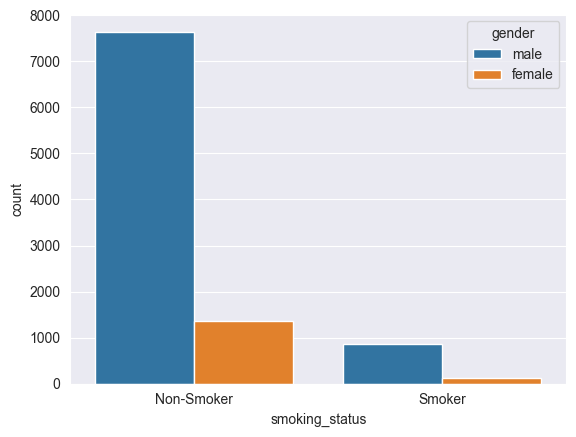

In [27]:
sns.countplot(data=df,x = 'smoking_status' ,hue='gender')

Можем оценить вероятность, что мужчина/женщина окажется курильщиком по ЦПТ, так как у нас большой объем выборки

## Обработка пропущенных значений и категориальных переменных

In [35]:
df.isna().sum()

id                   0
full_name            0
age               4555
gender               0
smoking_status       0
bmi               5348
blood_pressure    6234
glucose_levels    5244
condition            0
dtype: int64

В выборке по 4 переменным большое количество пропусков: от 45 до 62% 
- Точно не пойдет метод удаления строк с пропусками, так как мы потеряем большую часть данных
- Воспользуемся стратегией замены пропусков на среднее значение, метод позволяет сохранить характеристики распределения 

In [41]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
x = df[['gender', 'smoking_status', 'age', 'bmi', 'blood_pressure', 'glucose_levels']].values
y = df.iloc[:, -1].values
x_dirty = x.copy()
transformers  = [
    ('onehot', OneHotEncoder(), [0]),
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean'), [2, 3, 4, 5])
]
ct = ColumnTransformer(transformers)

x_transformed = ct.fit_transform(x_dirty)
x_transformed[:4, :], x[:4], y[:10]


(array([[  0.        ,   1.        ,  53.5415978 ,  27.42341987,
         135.20942869, 135.21960844],
        [  0.        ,   1.        ,  30.        ,  27.42341987,
         105.31506426, 135.21960844],
        [  0.        ,   1.        ,  18.        ,  35.61248566,
         135.20942869, 135.21960844],
        [  0.        ,   1.        ,  53.5415978 ,  27.42341987,
          99.11982938, 135.21960844]]),
 array([['male', 'Non-Smoker', nan, nan, nan, nan],
        ['male', 'Non-Smoker', 30.0, nan, 105.31506426419374, nan],
        ['male', 'Non-Smoker', 18.0, 35.61248565817603, nan, nan],
        ['male', 'Non-Smoker', nan, nan, 99.11982937713174, nan]],
       dtype=object),
 array(['Pneumonia', 'Diabetic', 'Pneumonia', 'Pneumonia', 'Diabetic',
        'Diabetic', 'Cancer', 'Diabetic', 'Diabetic', 'Diabetic'],
       dtype=object))

Получили: 

Condition

   0. Cancer
   1. Diabetic
   2. Pneumonia
    
Smoking-status 

   0. Non-smoker
   1. smoker
     
Gender:

   0. male
   1. female
   

In [43]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
y = le.fit_transform(y)
df1 = pd.DataFrame(
    x_transformed,
    columns = ['gender', 'isSmoker', 'age', 'bmi', 'blood_pressure', 'glucose_levels']
)

df1['condition'] = y
df1.head()

,gender,isSmoker,age,bmi,blood_pressure,glucose_levels,condition
0,0.0,1.0,53.541598,27.423420,135.209429,135.219608,2
1,0.0,1.0,30.000000,27.423420,105.315064,135.219608,1
2,0.0,1.0,18.000000,35.612486,135.209429,135.219608,2
3,0.0,1.0,53.541598,27.423420,99.119829,135.219608,2
4,0.0,1.0,76.000000,27.423420,135.209429,135.219608,1


In [40]:
df1.describe()

,gender,isSmoker,age,bmi,blood_pressure,glucose_levels,condition
count,10000.0000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.1494,0.8506,53.541598,27.423420,135.209429,135.219608,1.106700
std,0.3565,0.3565,15.440046,4.931837,15.979777,25.934211,0.622378
min,0.0000,0.0000,18.000000,15.012119,90.009620,70.015961,0.000000
25%,0.0000,1.0000,50.000000,27.423420,135.209429,135.219608,1.000000
50%,0.0000,1.0000,53.541598,27.423420,135.209429,135.219608,1.000000
75%,0.0000,1.0000,56.250000,27.423420,135.209429,135.219608,2.000000
max,1.0000,1.0000,89.000000,39.998687,179.999359,199.890429,2.000000


## Разделение выборки на тестовую и тренировочную

In [47]:
from sklearn.model_selection import train_test_split

x_train, x_holdout, y_train, y_holdout =\
    train_test_split(
                    df1.iloc[:, :-1], 
                    df1['condition'],
                    test_size=0.2,
                    train_size=0.8,
                    random_state=10
    )

Чаще всего выборку делят на тестовую и тренировочную в соотношении 20/80 или 30/70